<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Global-Fidelity-of-axiomatic-explanations-for-neural-rankers" data-toc-modified-id="Global-Fidelity-of-axiomatic-explanations-for-neural-rankers-1">Global Fidelity of axiomatic explanations for neural rankers</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-data,-split-holdout" data-toc-modified-id="Load-data,-split-holdout-1.0.1">Load data, split holdout</a></span></li><li><span><a href="#5-fold-CV-on-the-training-set" data-toc-modified-id="5-fold-CV-on-the-training-set-1.0.2">5-fold CV on the training set</a></span></li><li><span><a href="#Global-fidelity-(5-fold-CV-over-training-queries'-concordant-pairs)" data-toc-modified-id="Global-fidelity-(5-fold-CV-over-training-queries'-concordant-pairs)-1.0.3">Global fidelity (5-fold CV over training queries' concordant pairs)</a></span><ul class="toc-item"><li><span><a href="#top-three-models-per-system" data-toc-modified-id="top-three-models-per-system-1.0.3.1">top three models per system</a></span></li><li><span><a href="#Feature-importance-in-top-performing-global-fidelity-models" data-toc-modified-id="Feature-importance-in-top-performing-global-fidelity-models-1.0.3.2">Feature importance in top-performing global-fidelity models</a></span></li></ul></li><li><span><a href="#Global-explanation-fidelity-(transfer-to-hold-out-queries)" data-toc-modified-id="Global-explanation-fidelity-(transfer-to-hold-out-queries)-1.0.4">Global explanation fidelity (transfer to hold-out queries)</a></span><ul class="toc-item"><li><span><a href="#Global-explanation-fidelity,-binned-by-rank-difference" data-toc-modified-id="Global-explanation-fidelity,-binned-by-rank-difference-1.0.4.1">Global explanation fidelity, binned by rank difference</a></span></li><li><span><a href="#Global-explanation-fidelity,-binned-by-upper-rank" data-toc-modified-id="Global-explanation-fidelity,-binned-by-upper-rank-1.0.4.2">Global explanation fidelity, binned by upper rank</a></span></li></ul></li><li><span><a href="#Global-explanation-fidelity,-binned-by-both" data-toc-modified-id="Global-explanation-fidelity,-binned-by-both-1.0.5">Global explanation fidelity, binned by both</a></span></li></ul></li></ul></li></ul></div>

In [20]:
%matplotlib inline
%run -i experiments_common.py


In [2]:
%run -i spark_setup_local.py
spark

# Global Fidelity of axiomatic explanations for neural rankers

We train one model across all queries. (i.e. one model per system)

In [3]:
dataset_path = f'file://{os.path.realpath("../pref_pair_sets/2019-05-01_uniform-samples_21-axioms.jsonl")}'

dataset_sparkdf = spark.read.json(dataset_path)

In [4]:
dataset_sparkdf.printSchema()

root
 |-- ax_AND: long (nullable = true)
 |-- ax_DIV: long (nullable = true)
 |-- ax_LB1: long (nullable = true)
 |-- ax_LNC1: long (nullable = true)
 |-- ax_M_AND: long (nullable = true)
 |-- ax_M_TDC: long (nullable = true)
 |-- ax_PROX1: long (nullable = true)
 |-- ax_PROX2: long (nullable = true)
 |-- ax_PROX3: long (nullable = true)
 |-- ax_PROX4: long (nullable = true)
 |-- ax_PROX5: long (nullable = true)
 |-- ax_REG: long (nullable = true)
 |-- ax_STMC1: long (nullable = true)
 |-- ax_STMC1_f: long (nullable = true)
 |-- ax_STMC1_fr: long (nullable = true)
 |-- ax_STMC2: long (nullable = true)
 |-- ax_STMC2_f: long (nullable = true)
 |-- ax_STMC2_fr: long (nullable = true)
 |-- ax_TFC1: long (nullable = true)
 |-- ax_TFC3: long (nullable = true)
 |-- ax_TF_LNC: long (nullable = true)
 |-- concordant: long (nullable = true)
 |-- query: string (nullable = true)
 |-- rankdiff: long (nullable = true)
 |-- scorediff: double (nullable = true)
 |-- system: string (nullable = true)
 |-

### Load data, split holdout

randomly select 30 queries as hold-out; remove their rankings from the training data completely


In [5]:
query_ids = dataset_sparkdf.select('query').distinct().toPandas().values.flatten()
query_ids.sort()
systems = list(dataset_sparkdf.select('system').distinct().toPandas().values[:,0])
idx = np.arange(len(query_ids))
rnd = np.random.RandomState(seed=1)
rnd.shuffle(idx)
n_test = 30
holdout_queries = query_ids[idx[:n_test]]
train_queries = query_ids[idx[n_test:]]

train_sparkdf = dataset_sparkdf.where(dataset_sparkdf.query.isin(set(train_queries)))
holdout_sparkdf = dataset_sparkdf.where(dataset_sparkdf.query.isin(set(holdout_queries)))

print(train_sparkdf.count(), 'pairs in training set and', holdout_sparkdf.count(), 'pairs in holdout.')

# names of feature and class columns
col_predictors = [x for x in dataset_sparkdf.columns if x.startswith('ax_')]
col_response = 'concordant'

# mapping from system name to relevant training/testing data
trainsets_sys = {s: train_sparkdf.where(f'system == "{s}"') for s in systems}
testsets_sys = {s: holdout_sparkdf.where(f'system == "{s}"') for s in systems}

2147394 pairs in training set and 919260 pairs in holdout.


In [6]:
def description_of(parammap):
    def _desc(p, pv):
        if p.name == 'stages':
            return ('classifier', pv[-1].__class__.__name__)
        return (p.name, pv)    
    return dict(_desc(p, parammap[p]) for p in parammap)

def tblResults(cvModel):
    t = pd.DataFrame([dict(avgMetric=m, **description_of(pm)) for m,pm in zip(cvModel.avgMetrics, cvModel.getEstimatorParamMaps())])
    return t.apply(axis=1, func=lambda r: pd.Series(dict(
    avgMetric=r.avgMetric, classifier=r.classifier,
    params=dict(r[[x for x in r.index if x not in ['avgMetric', 'classifier'] and not np.isnan(r[x]) ]])
))).sort_values('avgMetric')
def subtbl(cvModels, s):
    t = tblResults(cvModels[s])
    t['system'] = s
    return t
jointResultsTbl = lambda cvModels: pd.concat([subtbl(cvModels, s) for s in systems]).sort_values('avgMetric')

### 5-fold CV on the training set

Train and validate a set of candite models (logistic regression, random forest, and gradient boosted tree) and parameter settings 

In [7]:
%%capture cap_train
%%time
import pyspark.ml as ml
import pyspark.ml.feature
import pyspark.ml.classification as mlc

xcol = '_featurevector'
ycol = '_bintarget'
cvseed = 1

pair2vec = ml.feature.VectorAssembler(inputCols=col_predictors, outputCol=xcol)
bintarget = ml.feature.Bucketizer(inputCol=col_response, outputCol=ycol, splits=[-1,0,1])
base_stages = [pair2vec, bintarget]

pipeline = pyspark.ml.Pipeline(stages=base_stages)

lr = mlc.LogisticRegression(featuresCol=xcol, labelCol=ycol)
lrgrid = (ml.tuning.ParamGridBuilder()
 .baseOn({pipeline.stages: base_stages + [lr]})
 .addGrid(lr.elasticNetParam, [1, .5, 0])
 .addGrid(lr.regParam, [.1, .01, 0.001])).build()

rf = mlc.RandomForestClassifier(featuresCol=xcol, labelCol=ycol)
rfgrid = (ml.tuning.ParamGridBuilder()
  .baseOn({pipeline.stages: base_stages + [rf]})
  .addGrid(rf.maxDepth, [10, 20])
  .addGrid(rf.numTrees, [64, 128])
).build()

gbt = mlc.GBTClassifier(featuresCol=xcol, labelCol=ycol)
gbtgrid = (ml.tuning.ParamGridBuilder()
  .baseOn({pipeline.stages: base_stages + [gbt]})
  .addGrid(gbt.maxDepth, [10, 20])
  .addGrid(gbt.subsamplingRate, [.9,  1.0])
).build()

paramgrid = lrgrid + rfgrid + gbtgrid

crossval = ml.tuning.CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramgrid,
    evaluator=ml.evaluation.BinaryClassificationEvaluator(labelCol=ycol),
    seed=cvseed,
    numFolds=5,
    parallelism=32
)

cvModels = {
    s: crossval.fit(trainsets_sys[s]) for s in systems
}

In [8]:
cap_train.show()

CPU times: user 1min, sys: 14.8 s, total: 1min 15s
Wall time: 4h 43min 33s


### Global fidelity (5-fold CV over training queries' concordant pairs) 

In [9]:
t = jointResultsTbl(cvModels)

Average CV-Accuracy of the mest model per system

In [10]:
t[t.classifier.str.startswith('Log')]

,avgMetric,classifier,params,system
0,0.500000,LogisticRegression,"{'elasticNetParam': 1.0, 'regParam': 0.1}",MP-COS
0,0.500000,LogisticRegression,"{'elasticNetParam': 1.0, 'regParam': 0.1}",DRMM
3,0.577424,LogisticRegression,"{'elasticNetParam': 0.5, 'regParam': 0.1}",MP-COS
1,0.608722,LogisticRegression,"{'elasticNetParam': 1.0, 'regParam': 0.01}",MP-COS
4,0.609007,LogisticRegression,"{'elasticNetParam': 0.5, 'regParam': 0.01}",MP-COS
2,0.609289,LogisticRegression,"{'elasticNetParam': 1.0, 'regParam': 0.001}",MP-COS
5,0.609479,LogisticRegression,"{'elasticNetParam': 0.5, 'regParam': 0.001}",MP-COS
6,0.609499,LogisticRegression,"{'elasticNetParam': 0.0, 'regParam': 0.1}",MP-COS
8,0.609569,LogisticRegression,"{'elasticNetParam': 0.0, 'regParam': 0.001}",MP-COS
7,0.609580,LogisticRegression,"{'elasticNetParam': 0.0, 'regParam': 0.01}",MP-COS


In [11]:
t.groupby('system')[['avgMetric']].max()

,avgMetric
system,
DRMM,0.683746
MP-COS,0.643098
PACRR-DRMM,0.740138


In [29]:
store_experiment(data=dict(
                item_id='glo-cv', Scope='Global', 
                Scope_detail='cv on 70 train queries',
                Perfmeasure='5-fold CV accuracy',
                Features=col_predictors,
                Num_models_per_system_per_fold=1,
                Num_train_per_fold=(4*2147394 / 5),
                Num_test_per_fold=(2147394 / 5),
                **{'accuracy_%s'%k.replace('-', '_'):v for k,v in t.groupby('system').avgMetric.max().items()}
))

Explanation fidelity for global models is mediocre in a cross-validated setting; PACRR-DRMM is most explainable by far.

#### top three models per system

In [12]:
from IPython import display

for s in systems:
    i = t[t.system == s].tail(3)
    display.display(i)

,avgMetric,classifier,params,system
13,0.642581,GBTClassifier,"{'maxDepth': 10.0, 'subsamplingRate': 0.9}",MP-COS
12,0.643043,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 128.0}",MP-COS
11,0.643098,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 64.0}",MP-COS


,avgMetric,classifier,params,system
13,0.682786,GBTClassifier,"{'maxDepth': 10.0, 'subsamplingRate': 0.9}",DRMM
11,0.683709,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 64.0}",DRMM
12,0.683746,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 128.0}",DRMM


,avgMetric,classifier,params,system
13,0.739563,GBTClassifier,"{'maxDepth': 10.0, 'subsamplingRate': 0.9}",PACRR-DRMM
11,0.740098,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 64.0}",PACRR-DRMM
12,0.740138,RandomForestClassifier,"{'maxDepth': 20.0, 'numTrees': 128.0}",PACRR-DRMM


**Conclusion:** RF with maxdepth=20 is the way to go; more trees usually better, but doubtful if the difference between 64 and 128 trees is significant

#### Feature importance in top-performing global-fidelity models

In [13]:
def feature_importances(cvModels, fcols=list(col_predictors)):
    fimps = []

    for s in systems:
        fimp = cvModels[s].bestModel.stages[-1].featureImportances
        fimps.extend([{'feature': p[3:] if p.startswith('ax_') else p, 'importance': i, 'system': s} for p,i in zip(fcols, fimp)])

    d = pd.DataFrame(fimps)
    d = d.pivot(index='feature', columns='system', values='importance')

    d = d / d.max(axis=0)
    d['ax_order'] = d.mean(axis=1)
    d['feature'] = d.index
    ord=d.sort_values('ax_order',ascending=False).index
    d=d.drop('ax_order',axis=1)
    sns.barplot(data=d.melt(id_vars=['feature']),
                y='feature',x='value',hue='system',
                order=ord,hue_order=systems,orient='h')
    plt.grid()
    plt.title('Relative Feature Importances for Global Models')
    plt.xlabel('Feature importance (fraction of most important)')
    plt.ylabel('Axiom Features ordered by average importance across systems')
    plt.gcf().set_size_inches((8,8))
    return d

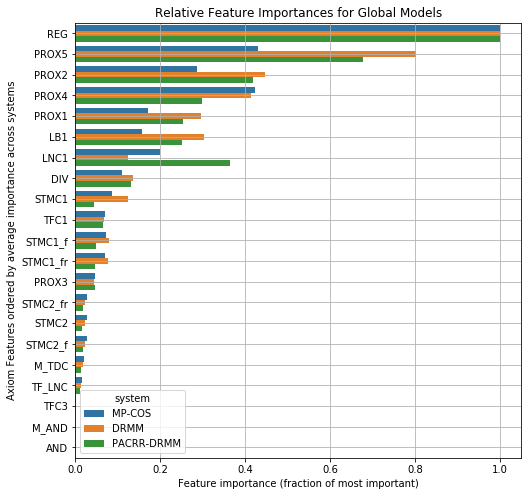

In [14]:
d = feature_importances(cvModels)

##### Feature importance correlation between systems 

In [15]:
d.corr(method='kendall').round(2)

system,DRMM,MP-COS,PACRR-DRMM
system,,,
DRMM,1.00,0.93,0.88
MP-COS,0.93,1.00,0.90
PACRR-DRMM,0.88,0.90,1.00


**Observation:** strong agreement on what the most important features are between all models

### Global explanation fidelity (transfer to hold-out queries) 

Take the best-performing model from the cv experiments above and apply them to the hold-out queries


In [16]:
def accuracy_on_holdout(cvModels):
    print("Accuracy on hold-out queries by system (correct predictions of concordance)")
    print("***************************************************************************")

    cbrs = []

    for s in systems:
        tested = cvModels[s].transform(testsets_sys[s])
        tested = tested.withColumn('correct', tested[ycol] == tested.prediction)
        m = tested.select('correct').toPandas().values.mean()
        print(f'{s}: {m:.3f}')

        df = tested.select(['upper_rank', 'rankdiff', 'correct']).toPandas()
        df['system'] = s
        cbrs.append(df)

    return pd.concat(cbrs, ignore_index=True)

In [17]:
cbrs = accuracy_on_holdout(cvModels)

Accuracy on hold-out queries by system (correct predictions of concordance)
***************************************************************************
MP-COS: 0.582
DRMM: 0.587
PACRR-DRMM: 0.688


In [31]:
store_experiment(data=dict(
                item_id='glo-holdout', Scope='Global', 
                Scope_detail='accuracy on 30 holdout queries',
                Perfmeasure='holdout accuracy',
                Features=col_predictors,
                Num_models_per_system_per_fold=1,
                Num_train_per_fold=(4*2147394 / 5),
                Num_test_per_fold=919260,
                **{'accuracy_%s'%k.replace('-', '_'):v for k,v in cbrs.groupby('system').correct.mean().items()}
))

**Observation:** massive loss in performance when transferring to hold-out queries not seen during training

**Conclusion:** query locality has strong influence on explanation fidelity

#### Global explanation fidelity, binned by rank difference

Bin pairs in hold-out query rankings into equal-sized subgroups per rank difference

[  1.   8.  18.  37.  60.  81. 103. 125. 149. 170. 193. 219. 247. 274.
 302. 329. 357. 394. 426. 461. 499. 544. 590. 643. 705. 791. 989.]
35356.2 pairs per bin on average.


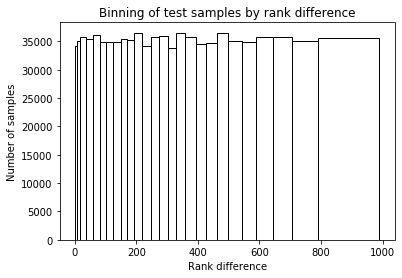

In [18]:
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    cbrs.rankdiff, np.linspace(0,1,27))
print(bin_edges)
plt.hist(cbrs.rankdiff, bin_edges, color='w', edgecolor='k')
plt.title('Binning of test samples by rank difference')
plt.xlabel('Rank difference')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
cbrs['bin'] = cbrs.rankdiff.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{cbrs.groupby("bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

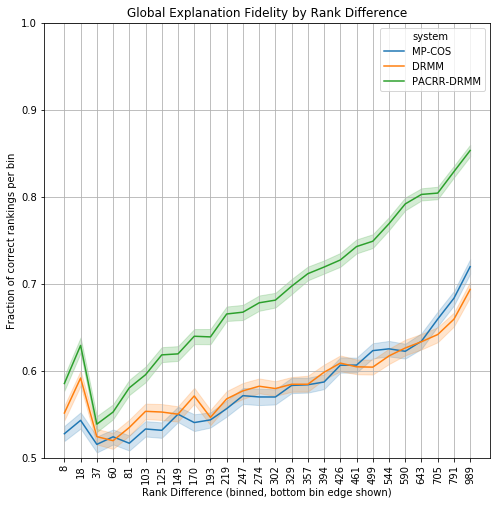

In [32]:
#bin_labels = [f'rd < {bin_edges[0]}'] + [f'{bin_edges[i-1]} <= rd < {bin_edges[i]}' for i in range(1, len(bin_edges))]
bin_labels = ['%.0f'%x for x in bin_edges]
sns.lineplot(x='bin', y='correct', hue='system', ci=95, data=cbrs)
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.grid()
plt.xlabel('Rank Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Global Explanation Fidelity by Rank Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))

**Observation:** For all systems, the globally-trained model's explanation fidelity improves with increasing rank difference, even though close pairs are much more common in the training data (there was no instance weighting during training above)

**Conclusion:** it makes sense to consider rank locality or rank-difference locality in addition to query locality

#### Global explanation fidelity, binned by upper rank

Bin pairs in hold-out query rankings into equal-sized subgroups per upper-rank

[  1.  18. 165. 249. 310. 366. 406. 444. 482. 516. 545. 577. 605. 630.
 657. 684. 704. 731. 752. 776. 800. 823. 845. 865. 887. 909. 927. 945.
 965. 982. 999.]
30642.0 pairs per bin on average.


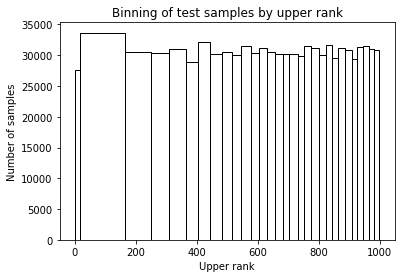

In [37]:
from scipy import stats
bin_edges = stats.mstats.mquantiles(
    cbrs.upper_rank, np.linspace(0,1,31))
print(bin_edges)
plt.hist(cbrs.upper_rank, bin_edges, color='w', edgecolor='k')
plt.title('Binning of test samples by upper rank')
plt.xlabel('Upper rank')
plt.ylabel('Number of samples')
bin_edges = bin_edges[1:]
cbrs['bin'] = cbrs.upper_rank.map(lambda rd: bin_edges.searchsorted(rd))
print(f'{cbrs.groupby("bin").count().mean().iloc[0]:.1f} pairs per bin on average.')

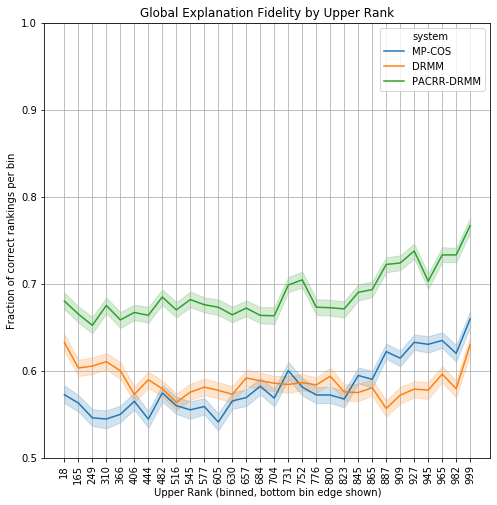

In [36]:
#bin_labels = [f'rd < {bin_edges[0]}'] + [f'{bin_edges[i-1]} <= rd < {bin_edges[i]}' for i in range(1, len(bin_edges))]
bin_labels = ['%.0f'%x for x in bin_edges]
sns.lineplot(x='bin', y='correct', hue='system', ci=95, data=cbrs)
plt.xticks(np.arange(len(bin_labels)), bin_labels, rotation=90)
plt.grid()
plt.xlabel('Upper Rank (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Global Explanation Fidelity by Upper Rank')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))

### Global explanation fidelity, binned by both

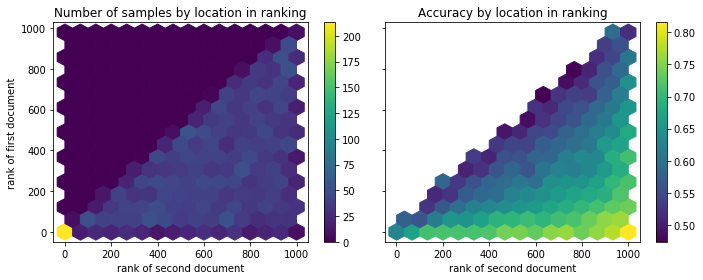

In [119]:
ranking_hexbin_plot(cbrs, gridsize=15)